# End-to-end Multi-class Dog Breed Classification

This notebook builds an end-to-end multi-class image classifier using TensorFlow 2.0 and TensorFlow Hub.

## 1. Problem

Identifying the breed of a dog given an image of a dog.

When I'm sitting at the cafe and I take a photo of a dog, I want to know what breed of dog it is.

## 2. Data

The data the we're using is from Kaggle's dog breed identification competition.

https://www.kaggle.com/competitions/dog-breed-identification/data

## 3. Evaluation

The evaluation is a file with prediction probablilities for each dog breed of each dog breed of each test image.

https://www.kaggle.com/competitions/dog-breed-identification/overview/evaluation

## 4. Features

Some information about the data:

 * We're dealing with images (unstructured data) so it's probably best we use deep learning/transfer learning
 * There are 120 breeds of dogs (this means there are 120 different classes)
 * There are around 10,000+ images in the training set (these images have labels)
 * There are around 10,000+ images in the test set (these images have no labels, because we'll want to predict them)

In [1]:
# !unzip "drive/MyDrive/Colab Notebooks/dog-vision/dog-breed-identification.zip" -d "drive/MyDrive/Colab Notebooks/dog-vision/"

### Get our workspace ready
 * Import TensorFlow 2.0+
 * Import TensorFlow Hub
 * Make sure w are using a GPU


In [2]:
# import necessary tools
import tensorflow as tf
import tensorflow_hub as hub
print('TF version:', tf.__version__)
print('TF hub version:', tf.__version__)

# check for GPU
print('GPU: ', 'available' if tf.config.list_physical_devices('GPU') else 'not available')

TF version: 2.15.0
TF hub version: 2.15.0
GPU:  not available


## Getting our data ready (turning into Tensors)

With all machine learning models, our data has to be in numerical format. So that's what we'll be doing first. Turning our images into Tensors (numerical representations).

Let's start by accessing our data and checking out the labels.

In [3]:
# checking out the labels of our data
import pandas as pd
labels_csv = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dog-vision/labels.csv')

In [4]:
labels_csv.describe()

,id,breed
count,10222,10222
unique,10222,120
top,000bec180eb18c7604dcecc8fe0dba07,scottish_deerhound
freq,1,126


In [5]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


<Axes: >

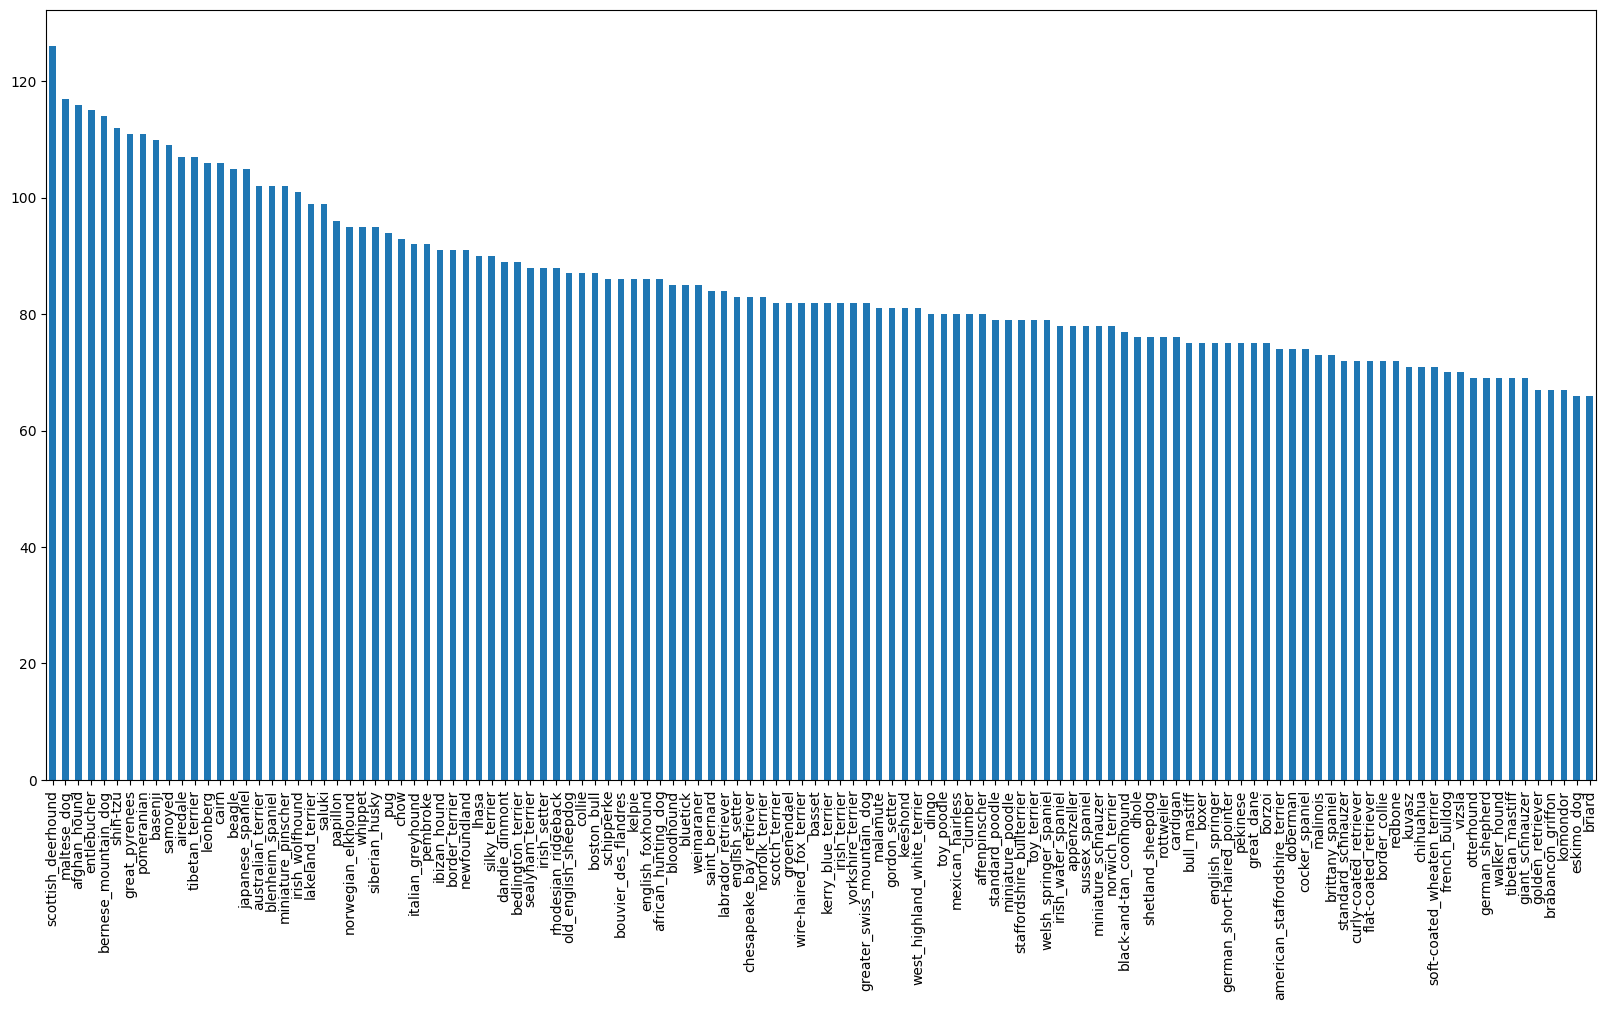

In [6]:
# how many images are there of each breed?
labels_csv['breed'].value_counts().plot.bar(figsize=(20, 10))

In [7]:
labels_csv['breed'].value_counts().median()

82.0

In [8]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


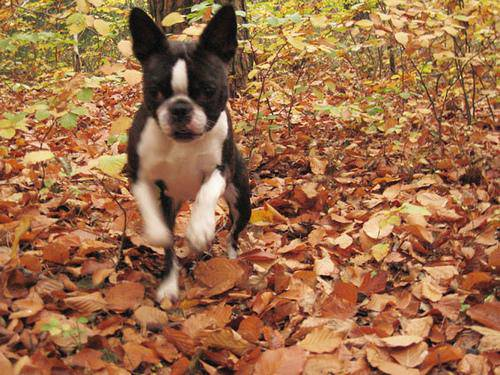

In [9]:
# let's view an image
from IPython.display import Image
Image('/content/drive/MyDrive/Colab Notebooks/dog-vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg')

### Getting images and their labels

Let's get a list of of all our image file pathnames

In [10]:
# create pathnames from image ID's
filenames = ['/content/drive/MyDrive/Colab Notebooks/dog-vision/train/' + fname + '.jpg' for fname in labels_csv['id']]

# check the first 10
filenames[:10]

['/content/drive/MyDrive/Colab Notebooks/dog-vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 '/content/drive/MyDrive/Colab Notebooks/dog-vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 '/content/drive/MyDrive/Colab Notebooks/dog-vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 '/content/drive/MyDrive/Colab Notebooks/dog-vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 '/content/drive/MyDrive/Colab Notebooks/dog-vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 '/content/drive/MyDrive/Colab Notebooks/dog-vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 '/content/drive/MyDrive/Colab Notebooks/dog-vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 '/content/drive/MyDrive/Colab Notebooks/dog-vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 '/content/drive/MyDrive/Colab Notebooks/dog-vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 '/content/drive/MyDrive/Colab Notebooks/dog-vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [11]:
# check if we have the complete data
import os
if len(os.listdir('/content/drive/MyDrive/Colab Notebooks/dog-vision/train')) == len(filenames):
  print('Amount of files matches the amount of filanames')
else:
  print('Amount of files do not match the amount of filenames')

Amount of files matches the amount of filanames


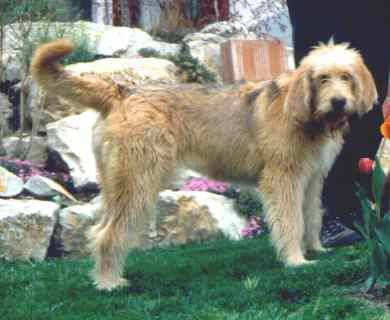

In [12]:
# check if filenames are valid
Image(filenames[21])

Preparing our labels

In [13]:
import numpy as np
labels = labels_csv['breed'].to_numpy()
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [14]:
len(labels)

10222

In [15]:
# check if the number of labels match the number of filenames
if len(labels) == len(filenames):
  print('Number of labels match the number of filenames')
else:
  print('Number of labels do not match the number of filenames')

Number of labels match the number of filenames


In [16]:
# find the unique label values
unique_breeds = np.unique(labels)
len(unique_breeds), unique_breeds

(120,
 array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
        'american_staffordshire_terrier', 'appenzeller',
        'australian_terrier', 'basenji', 'basset', 'beagle',
        'bedlington_terrier', 'bernese_mountain_dog',
        'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
        'bluetick', 'border_collie', 'border_terrier', 'borzoi',
        'boston_bull', 'bouvier_des_flandres', 'boxer',
        'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
        'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
        'chow', 'clumber', 'cocker_spaniel', 'collie',
        'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
        'doberman', 'english_foxhound', 'english_setter',
        'english_springer', 'entlebucher', 'eskimo_dog',
        'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
        'german_short-haired_pointer', 'giant_schnauzer',
        'golden_retriever', 'gordon_setter'

In [17]:
# turn a single label into an array of booleans
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [18]:
# turn every label into boolean array
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [19]:
len(boolean_labels)

10222

In [20]:
# example: turning boolean array into integers
print(labels[0])
print(np.where(unique_breeds == labels[0]))
print(boolean_labels[0].argmax())
print(boolean_labels[0].astype(int))

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [21]:
print(labels[2])
print(boolean_labels[2].astype(int))

pekinese
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [22]:
filenames[:10]

['/content/drive/MyDrive/Colab Notebooks/dog-vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 '/content/drive/MyDrive/Colab Notebooks/dog-vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 '/content/drive/MyDrive/Colab Notebooks/dog-vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 '/content/drive/MyDrive/Colab Notebooks/dog-vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 '/content/drive/MyDrive/Colab Notebooks/dog-vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 '/content/drive/MyDrive/Colab Notebooks/dog-vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 '/content/drive/MyDrive/Colab Notebooks/dog-vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 '/content/drive/MyDrive/Colab Notebooks/dog-vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 '/content/drive/MyDrive/Colab Notebooks/dog-vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 '/content/drive/MyDrive/Colab Notebooks/dog-vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

### Creating our own validation set

Since the dataset from Kaggle doesn't come with a validation set, we're going to create our own.

In [23]:
# set up X and y variables
X = filenames
y = boolean_labels

In [24]:
len(filenames)

10222

We're going to experiment on ~1000 images and increase as needed

In [25]:
# set number of images for experimentation
NUM_IMAGES = 1000 #@param {type:'slider', min:1000, max:10000, step:1000}

In [26]:
# splitting our data into training and validation sets
from sklearn.model_selection import train_test_split

# split them into training and validation of total size NUM_IMAGES
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES], y[:NUM_IMAGES], test_size=0.2)

len(X_train), len(X_val), len(y_train), len(y_val)

(800, 200, 800, 200)

In [27]:
# let's have a peek at our data
X_train[:2], y_train[:2]

(['/content/drive/MyDrive/Colab Notebooks/dog-vision/train/00fa641312604199831755f96109fde7.jpg',
  '/content/drive/MyDrive/Colab Notebooks/dog-vision/train/008ba178d6dfc1a583617470d19c1673.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         Fa

## Preprocessing Images (turning images into Tensors)

To preprocess our images we need to write a function which does the following:

1. Take an image filepath as input
2. Use TensorFlow to to reach the file and save it into variable, `image`
3. Turn our `image` (jpg) into tensors
4. Resize the `image` to be a shape of (224, 224)
5. Return the modified `image`

A glimpse of what we are going to do:

In [28]:
# convert image to NumPy array
from matplotlib.pyplot import imread
image = imread(filenames[42])
image.shape

(257, 350, 3)

In [29]:
image[:2]

array([[[ 89, 137,  89],
        [ 76, 124,  76],
        [ 63, 111,  61],
        ...,
        [ 77, 133,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  75],
        [ 67, 114,  68],
        [ 63, 110,  64],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 132,  84]]], dtype=uint8)

In [30]:
# image into tensor
tf.constant(image[:2])

<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  89],
        [ 76, 124,  76],
        [ 63, 111,  61],
        ...,
        [ 77, 133,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  75],
        [ 67, 114,  68],
        [ 63, 110,  64],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 132,  84]]], dtype=uint8)>

Now we've seen what an image looks like as a Tensor, let's make a function to preprocess them

1. Take an image filepath as input
2. Use TensorFlow to to reach the file and save it into variable, `image`
3. Turn our `image` (jpg) into tensors
4. Normalize our image (convert color channel values from 0-255 to 0-1)
5. Resize the `image` to be a shape of (224, 224)
6. Return the modified `image`


In [31]:
# define image size
IMG_SIZE = 224

# create a function for preprocessing image
def process_image(img_path, img_size = IMG_SIZE):
  '''
  Takes an image filepath and turns image into a tensor
  '''

  # read in an image file
  image = tf.io.read_file(img_path)
  # turn the jpeg image into numerical Tensor with 3 color channels (Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=3)
  # convert the color channels from 0-255 to 0-1
  image = tf.image.convert_image_dtype(image, tf.float32)
  # resize the image to our desired value (224, 224)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])
  return image


### Turning our data into batches

Why turn our data into batches?

Let's say you're trying to process 10,000+ images in one go, they all might not fit into memory.

So that's why we do about 32 (this is the batch size) images at a time (you can manually adjust the batch size if need be)

In order to use TensorFlow effectively, we need our data in the form of Tensor tuples which look like this: `(image, label)`

In [32]:
# create a simple function to return a tuple (image, label)
def get_image_label(img_path, label):
  '''
  Takes an image file pathname and the associated label, process the image then returns a tuple of (image, label)
  '''
  image = process_image(img_path)
  return image, label

In [33]:
# demo of the above function
get_image_label(X[22], tf.constant(y[22]))

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.1330032 , 0.05492197, 0.08260179],
         [0.12281288, 0.04473164, 0.07286915],
         [0.10271296, 0.02463172, 0.05307436],
         ...,
         [0.5843801 , 0.2659036 , 0.23074335],
         [0.42622918, 0.17718755, 0.12505569],
         [0.24508326, 0.04996776, 0.01638262]],
 
        [[0.4086272 , 0.375257  , 0.39908588],
         [0.36725003, 0.33319327, 0.35938936],
         [0.29389817, 0.25938374, 0.28715795],
         ...,
         [0.44133395, 0.20268634, 0.185602  ],
         [0.36695412, 0.16867074, 0.15405174],
         [0.2550185 , 0.08574145, 0.07356845]],
 
        [[0.56696117, 0.58506346, 0.6011555 ],
         [0.5850034 , 0.6031056 , 0.6203419 ],
         [0.5720782 , 0.59018046, 0.6081795 ],
         ...,
         [0.13036056, 0.00890197, 0.00958708],
         [0.24564041, 0.12379038, 0.15058532],
         [0.19309051, 0.06804112, 0.1088118 ]],
 
        ...,
 
        [[0.45460117, 0.4624443 

Now we've got a way to turn our data into tuples of Tensors in the form `(image,labels)`, let's make a function to turn all of our data (X and y)  into batches.

In [34]:
# define the batch size
BATCH_SIZE = 32

# create function to turn data into batches
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  '''
  Creates batches of data out of image (X) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle if it's validation data.
  Also accepts test data as input (no labels)
  '''

  # if the data is a test dataset, we probably don't have the labels
  if test_data:
    print('Creating test data batches...')
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # filepaths with no labels
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch

  # if data is a valid dataset, we don't need to shuffle it
  elif valid_data:
    print('Creating valid data batches...')
    data = tf.data.Dataset.from_tensor_slices( (tf.constant(X), # filepath
                                                tf.constant(y)) ) # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    print('Creating training data batchess...')
    # turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices( (tf.constant(X),
                                                tf.constant(y)) )
    # shuffling pathnames and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(X))

    # create (image, label) tuples (this also turns the image path into a processed image)
    data = data.map(get_image_label)

    # turn the training data into batches
    data_batch = data.batch(BATCH_SIZE)
  return data_batch

In [35]:
# create training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batchess...
Creating valid data batches...


In [36]:
# check out the different attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

### Visualizing Data Batches

Our data is now in batches, however, these can be a little hard to understand/comprehend, let's visualize them.

In [37]:
import matplotlib.pyplot as plt

# number of images shown
IMG_COUNT = 25

# create function for viewing images in a data batch
def show_images(images, labels, img_count=IMG_COUNT):
  '''
  Displays a plot of IMG_COUNT images and their labels from a data batch.
  '''
  # setup the figure
  plt.figure(figsize=(10, 10))
  # loop through IMG_COUNT
  for i in range(IMG_COUNT):
    # create subplots of 5 rows and 5 columns
    ax = plt.subplot(5, 5, i + 1)
    # display an image
    plt.imshow(images[i])
    # add the image label as the title
    plt.title(unique_breeds[labels[i].argmax()])
    # turn the grid lines off
    plt.axis('off')

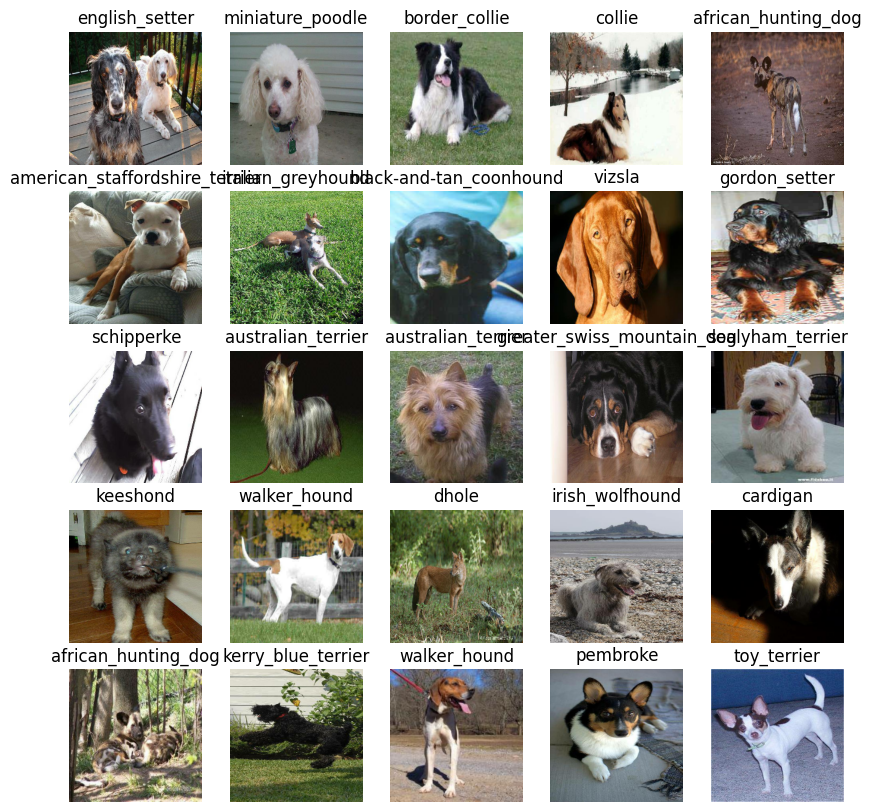

In [38]:
# Now let's visualize the data in training batch
train_images, train_labels = next(train_data.as_numpy_iterator())
show_images(train_images, train_labels)

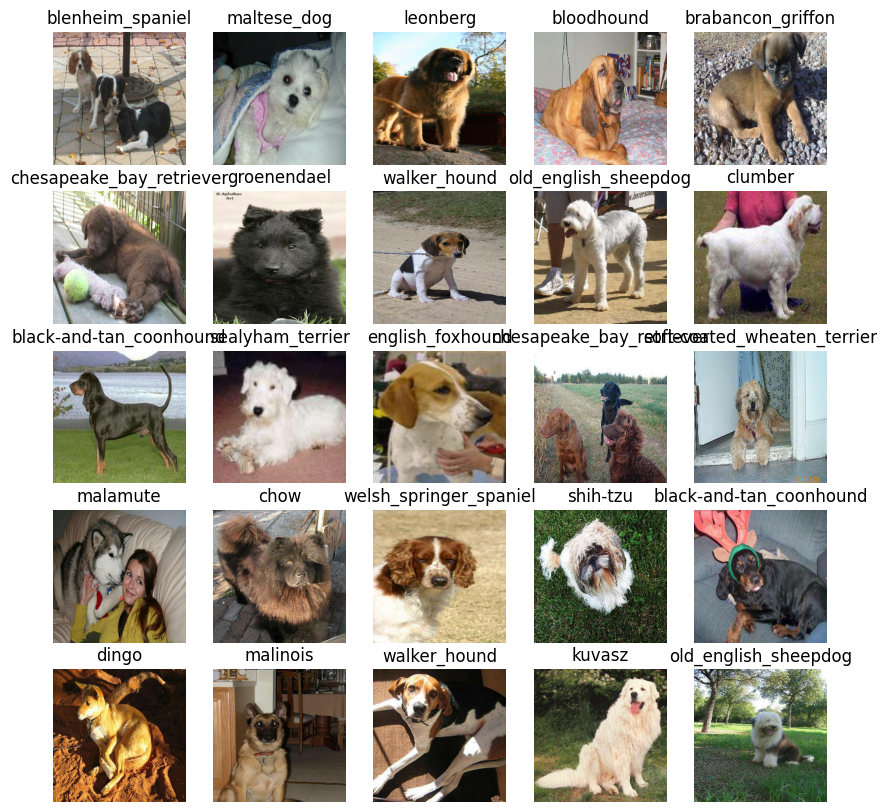

In [39]:
# now let's visualize our validation set
val_images, val_labels = next(val_data.as_numpy_iterator())
show_images(val_images, val_labels)